In [1]:
import os
from functools import partial
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis import load_sim_states, load_toml, get_vehicle_arrival_and_exits, display_and_save_animation
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, mannwhitneyu
from IPython.display import HTML

### Set-up config files and run with single seed

In [2]:
# Seed
SEED = 0

# png dpi
DPI = 300

# File names for two crossings
config_file2 = "zebra_config_2crossings.toml"
outfile2 = "sim_states_2crossings.json"

# File names for three crossings
config_file3 = "zebra_config_3crossings.toml"
outfile3 = "sim_states_3crossings.json"

# Based on real locations of crossings and road length
first_zebra = 180 # (0m)
proposed_zebra = 340 # (160m from first zebra)
second_zebra = 480 # (300m from first zebra)
road_length = 660 # Buffer of 180m either side of first and last crossing

In [3]:
%%writefile $config_file2
road_length = 660
zebra_crossings = [180, 480]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting zebra_config_2crossings.toml


In [4]:
%%writefile $config_file3
road_length = 660
zebra_crossings = [180, 340, 480]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting zebra_config_3crossings.toml


In [5]:
# Make "call" partial fn for convenience, returns failures unlike "!"
call = partial(subprocess.check_call, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [6]:
# Run the simulations
call(["cargo", "run", "--", "--config_file", config_file2, "--outfile", outfile2, "--seed", str(SEED)])
call(["cargo", "run", "--", "--config_file", config_file3, "--outfile", outfile3, "--seed", str(SEED)])

0

In [7]:
# These are debug cases
call(["cargo", "run", "--", "--config_file", config_file2, "--outfile", outfile2, "--seed", str(37)])
call(["cargo", "run", "--", "--config_file", config_file3, "--outfile", outfile3, "--seed", str(37)])

0

In [8]:
# Load zebra toml and outfiles
zebra_toml2 = load_toml(config_file2)
states2 = load_sim_states(outfile2)
zebra_toml3 = load_toml(config_file3)
states3 = load_sim_states(outfile3)

In [9]:
# Get dataframes for two and three crossing versions
df2 = get_vehicle_arrival_and_exits(states2)
df3 = get_vehicle_arrival_and_exits(states3)

> Mean transit times:
Two crossings:   58.305s
Three crossings: 56.883s
> Median transit times:
Two crossings:   56.144s
Three crossings: 55.552s


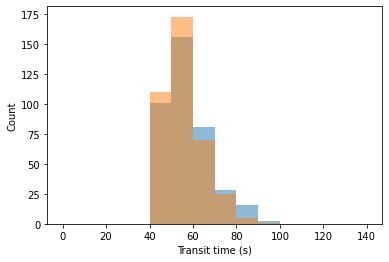

In [10]:
# Plot hists, compare means and medians
bins = np.arange(0, 150, 10)
alpha = 0.5
plt.hist(df2["transit"], bins=bins, alpha=alpha)
plt.hist(df3["transit"], bins=bins, alpha=alpha)
plt.ylabel("Count")
plt.xlabel("Transit time (s)")
mean2, median2 = df2["transit"].mean(), df2["transit"].median()
mean3, median3 = df3["transit"].mean(), df3["transit"].median()
print(f"> Mean transit times:")
print(f"Two crossings:   {mean2:.3f}s")
print(f"Three crossings: {mean3:.3f}s")
print(f"> Median transit times:")
print(f"Two crossings:   {median2:.3f}s")
print(f"Three crossings: {median3:.3f}s")

> Mean transit times:
Two crossings:   58.305s
Three crossings: 56.883s
> Median transit times:
Two crossings:   56.144s
Three crossings: 55.552s


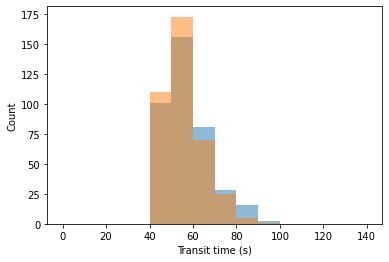

In [11]:
# Plot hists, compare means and medians
bins = np.arange(0, 150, 10)
alpha = 0.5
plt.hist(df2["transit"], bins=bins, alpha=alpha)
plt.hist(df3["transit"], bins=bins, alpha=alpha)
plt.ylabel("Count")
plt.xlabel("Transit time (s)")
mean2, median2 = df2["transit"].mean(), df2["transit"].median()
mean3, median3 = df3["transit"].mean(), df3["transit"].median()
print(f"> Mean transit times:")
print(f"Two crossings:   {mean2:.3f}s")
print(f"Three crossings: {mean3:.3f}s")
print(f"> Median transit times:")
print(f"Two crossings:   {median2:.3f}s")
print(f"Three crossings: {median3:.3f}s")

In [12]:
# Display and save animation
html = display_and_save_animation(states3, zebra_toml3, "zebra_3crossings.gif", frame_limit=2000, write=False)

display(HTML(html))
plt.close()

### Set-up and get averages across multiple runs

In [13]:
def run_sim_and_return_transit(config: str, seed: int):
    """Run simulation and return df with transit time."""
    outfile = f".outfile_{seed}.json"
    call([
        "../target/release/zebra",
        "--config_file", config,
        "--outfile", outfile,
        "--seed", str(seed)
    ])
    zebra_toml = load_toml(config)
    states = load_sim_states(outfile)
    os.remove(outfile)
    df = get_vehicle_arrival_and_exits(states)
    df["seed"] = seed
    return df

In [14]:
# Build release version for fastest runtime
call(["cargo", "build", "--release"])

0

In [15]:
# Number of simulations to aggregate
N_SEEDS = 1000

# Run simulations in parallel for two crossings
dfs2 = pd.concat(
    Parallel(n_jobs=-1)(
        delayed(run_sim_and_return_transit)(
            config_file2,
            seed
        )
        for seed in tqdm(range(N_SEEDS))
    )
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.72it/s]


In [16]:
# Run simulations in parallel for three crossings
dfs3 = pd.concat(
    Parallel(n_jobs=-1)(
        delayed(run_sim_and_return_transit)(
            config_file3,
            seed
        )
        for seed in tqdm(range(N_SEEDS))
    )
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.05it/s]


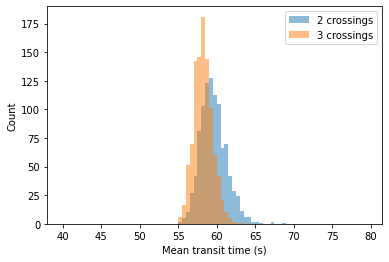

In [17]:
# Compare means
means2 = dfs2.groupby("seed")["transit"].mean()
means3 = dfs3.groupby("seed")["transit"].mean()

alpha = 0.5
bins = np.arange(40, 80, 0.5)
plt.hist(means2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(means3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel("Mean transit time (s)")
plt.savefig("plot_mean_comparison.pdf", bbox_inches="tight", transparent=True)

In [18]:
# Print hypothesis test results
print(f"Difference in mean of means: {np.mean(means2)-np.mean(means3):.3f}s")
print(ttest_ind(means2, means3))
print(mannwhitneyu(means2, means3))

Difference in mean of means: 1.341s
Ttest_indResult(statistic=20.126537624845795, pvalue=3.507633872619269e-82)
MannwhitneyuResult(statistic=739092.0, pvalue=1.5537157923297254e-76)


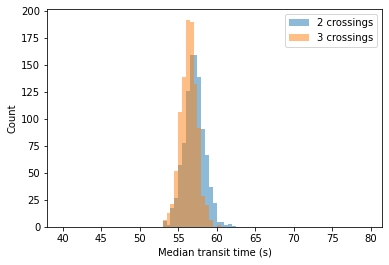

In [19]:
# Compare medians
medians2 = dfs2.groupby("seed")["transit"].quantile(0.5)
medians3 = dfs3.groupby("seed")["transit"].quantile(0.5)

plt.hist(medians2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(medians3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel("Median transit time (s)")
plt.savefig("plot_median_comparison.pdf", bbox_inches="tight", transparent=True)
plt.savefig("plot_median_comparison.png", bbox_inches="tight", transparent=True, dpi=DPI)

In [20]:
# Print hypothesis test results
print(f"Difference in mean of medians: {np.mean(medians2)-np.mean(medians3):.3f}s")
print(ttest_ind(medians2, medians3))
print(mannwhitneyu(medians2, medians3))

Difference in mean of medians: 0.704s
Ttest_indResult(statistic=13.057282373946824, pvalue=1.8810611331085665e-37)
MannwhitneyuResult(statistic=661673.5, pvalue=5.802706293435386e-36)


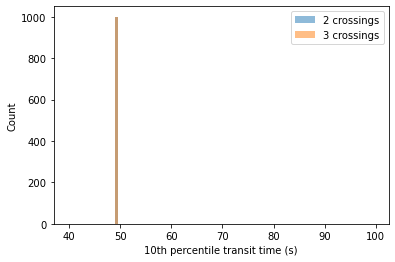

In [21]:
# Compare 10th percentile
q = 0.1
p10_2 = dfs2.groupby("seed")["transit"].quantile(q)
p10_3 = dfs3.groupby("seed")["transit"].quantile(q)

bins = np.arange(40, 100, 0.5)
plt.hist(p10_2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(p10_3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel(f"{q*100:.0f}th percentile transit time (s)")
plt.savefig("plot_lower_percentile_comparison.pdf", bbox_inches="tight", transparent=True)

In [22]:
# Print difference in mean for 10th percentile
print(f"Difference in mean of 10th percentile: {np.mean(p10_2)-np.mean(p10_3):.3f}s")

Difference in mean of 10th percentile: 0.000s


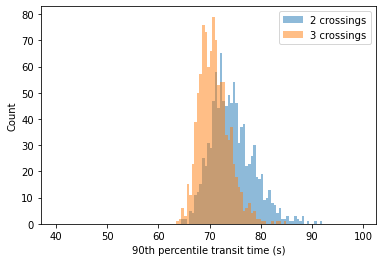

In [23]:
# Compare 90th percentile
q = 0.90
p90_2 = dfs2.groupby("seed")["transit"].quantile(q)
p90_3 = dfs3.groupby("seed")["transit"].quantile(q)

bins = np.arange(40, 100, 0.5)
plt.hist(p90_2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(p90_3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel(f"{q*100:.0f}th percentile transit time (s)")
plt.savefig("plot_upper_percentile_comparison.pdf", bbox_inches="tight", transparent=True)
plt.savefig("plot_upper_percentile_comparison.png", bbox_inches="tight", transparent=True, dpi=DPI)

In [24]:
# Print difference in mean
print(f"Difference in mean of 90th percentile: {np.mean(p90_2)-np.mean(p90_3):.3f}s")

Difference in mean of 90th percentile: 3.532s


## Next steps
- Sensitivities
- Analysis of distribution

### Sensitivities
- Vehicles arrive more quickly/slowly
- Pedestrians cross more slowly
- What is the optimal number of crossings for minimum transit time?

### Analysis
- For the different crossing numbers, is the distribution just a translation of $\Delta$s while maintaining same shape. e.g. could compute the KL divergence of the empirical distributions translated by mean and compare to some null.